In [8]:
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import applications, optimizers
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Flatten, Dense, Dropout
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop 
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow import keras

1.0 Data extraction

In [9]:
zip_file_path = "/Users/godfreykrutzsch/Desktop/platesv2/plates.zip"
extract_to = "/Users/godfreykrutzsch/Desktop/platesv2/"

In [10]:

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)
    zip_ref.close()

2.0 Exploration

In [11]:
data_directory = "/Users/godfreykrutzsch/Desktop/platesv2/plates"
print(os.listdir(data_directory))

['.DS_Store', 'test', 'train']


3.0 set directories

In [12]:
training_directory = data_directory + "/train"
test_directory = data_directory + "/test"

4.0 set global variables for image and batch sizes

In [13]:
# width & height images
image_size = 224
# the number of images in each batch during training.
batch_size = 32

5.0 Image preprocessing and loading

In [14]:
# this function generate batches of tensor image data with real time augmentation, it creates variations of images on the fly.

train_datagen = ImageDataGenerator(
        rotation_range=40,      # randomly rotate image up to 40 degrees 
        width_shift_range=0.2,  # randomly shift image horizontally by 20% of the width
        height_shift_range=0.2, # randomly shift image vertically by 20% of the height
        shear_range=0.2,        # randomly apply shear transformation
        zoom_range=0.2,         # randomly zoom into image
        horizontal_flip=True,   # randomly flip image horizontally 
        vertical_flip=True      # randomly flip image vertically
)
# create the train_generator with the augmentation applied
train_generator = train_datagen.flow_from_directory(
        training_directory,
        target_size=(image_size,image_size),
        batch_size=batch_size,
        class_mode='binary'
)

test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
        data_directory,
        classes=['test'],
        target_size=(image_size, image_size),
        batch_size=1,
)

Found 40 images belonging to 2 classes.
Found 744 images belonging to 1 classes.


In [15]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.45),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.4)
    
])

In [16]:
augmented_train_dataset = train_generator.map(lambda x,y: (data_augmentation(x, training=True), y)).repeat(300).shuffle(32)

AttributeError: 'DirectoryIterator' object has no attribute 'map'

6.0 Loading pre-trained model

In [25]:
base_model = applications.InceptionResNetV2(weights='imagenet', include_top=False,
                                            input_shape=(image_size,image_size, 3))

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 15s 0us/step


In [ ]:
# ensure pre-learned features are preserved by freezing the models base layers (the layers where it is pretrained as we do not want to overwrite these nor change in training!
base_model.trainable = False

7.0 Infrastructure CNN

7.1 Add new custom layers on top of frozen base_model

In [27]:
# extract pre-train InceptionRNV2 output, which is the input to the following custom layers
x = base_model.output

In [28]:
#converts the 2D matrix output of model to 1D vector. Why? it must be done before feeding the data into THE fully connected layer (Dense)
x = Flatten()(x)

In [29]:
# adds a fully connected layer. this layer is used to learn complex patterns from the flatten feature map.
x = Dense(1024, activation='relu')(x)

In [30]:
# this is a regularization technique to prevent overfitting by dropping a fraction of neurons during each training iteration.
x = Dropout(0.5)(x)

7.2 Final Prediction Layer

In [31]:
# this defines a fully connected layer with 1 output neuron. The sigmoid function  squash value to between 0 and 1 typical for classification tasks, where output represents that a given input belongs to a class e.g dirt plate.
prediction = Dense(1, activation='sigmoid')(x)

7.3 Model definition

In [34]:
# this create a keras model object which takes the input of the pre-trained base model (e.g. InceptionResNetv2) and outputs the final prediction layer. the prediction is the output layer of the entire model, which predicts if image is clean or dirty plate
model = Model(inputs=base_model.input, outputs=prediction)

8.0 Compile model

In [48]:
# this is a classification problem ´binary crossentropy´ is used as loss function(difference between predicted probabilities and actual.
# RMSprop is a optimizer for training neural networks
# lr=0.0001 inital learning rate
# metrics accuracy means model will track accuracy during training.
model.compile(loss='binary_crossentropy', optimizer=RMSprop(learning_rate=0.0001, decay=1e-6), metrics=['accuracy'])

In [44]:
#model.summary()
# draw model but does not take account of sequencing e.g. short cuts avoiding Convol layers as of Resnet.
keras.utils.plot_model(model, show_shapes=True)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.17423 to fit



9.0 Training

In [49]:
# calculate steps_per_epoch based on numer of samples and batch size
num_samples = train_generator.samples # total number of samples in train generator
batch_size_ = train_generator.batch_size

steps_per_epoch = num_samples // batch_size_
print(steps_per_epoch)

5


In [104]:
# train model with history object
history = model.fit(
        train_generator, 
        steps_per_epoch=1000,                       
        epochs=40,              # train for 10 full cycles through training date  
        verbose=1,              # show progress bar
        )

Epoch 1/40
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 1.0000 - loss: 2.7241e-05 
Epoch 2/40


/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8995 - loss: 0.5099  
Epoch 3/40
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 1.0000 - loss: 0.0141  
Epoch 4/40
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 1.0000 - loss: 2.3847e-04 
Epoch 5/40
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 1.0000 - loss: 2.4196e-04  
Epoch 6/40
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 1.0000 - loss: 0.0017  
Epoch 7/40
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 1.0000 - loss: 8.0567e-04  
Epoch 8/40
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 1.0000 - loss: 0.0057  
Epoch 9/40
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 1.0000 - loss: 0.0014  
Epoch 10/40
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 1.0000 - loss: 1.2394e-04  
Epoch 11/40
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 1.0000 - loss: 1.3213e-04  
Epoch 12/40
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 1.0000 - loss: 1.2068e

2024-09-04 14:52:10.057718: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 1.0000 - loss: 5.8304e-05  
Epoch 30/40
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 1.0000 - loss: 1.1382e-04  
Epoch 31/40
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 1.0000 - loss: 0.0012  
Epoch 32/40
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 1.0000 - loss: 9.9411e-05  
Epoch 33/40
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 1.0000 - loss: 6.3995e-05  
Epoch 34/40
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9499 - loss: 0.1655  
Epoch 35/40
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9750 - loss: 0.0969  
Epoch 36/40
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 1.0000 - loss: 1.3048e-04  
Epoch 37/40
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9003 - loss: 0.6738  
Epoch 38/40
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 1.0000 - loss: 5.8630e-04  
Epoch 39/40
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9748 - lo

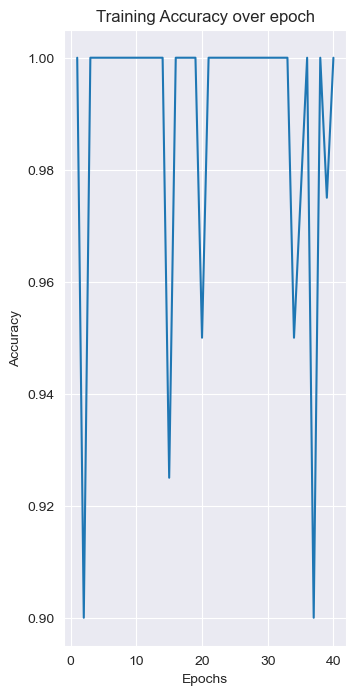

In [105]:
# access the accuracy and loss from history object
acc = history.history['accuracy']
loss = history.history['loss']

#Generate the range of epochs
epochs_range = range(1, len(acc)+1)

# plot the accuracy
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy over epoch")
plt.show()

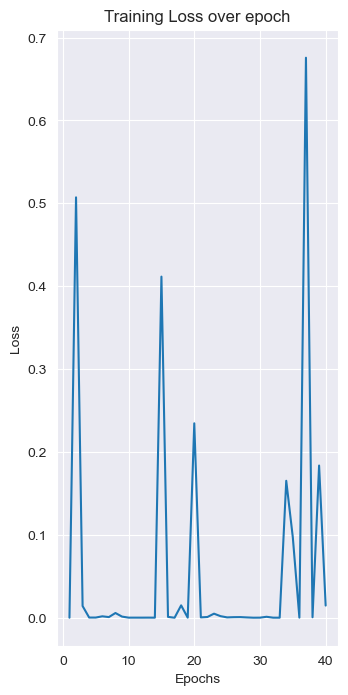

In [106]:
# plot the loss
plt.figure(figsize=(8,8))
plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss over epoch")
plt.show()

10 Prediction

In [90]:
test_generator.reset()
predict = model.predict(test_generator, steps = len(test_generator.filenames))
len(predict)

744/744 ━━━━━━━━━━━━━━━━━━━━ 58s 76ms/step


744

In [91]:
predict[:5]

array([[1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [0.78231597]], dtype=float32)

In [92]:
sub_df = pd.read_csv('/Users/godfreykrutzsch/Desktop/platesv2/sample_submission.csv')
sub_df.head()

,id,label
0,0,dirty
1,1,dirty
2,2,dirty
3,3,dirty
4,4,dirty


In [93]:
sub_df.label.value_counts()

label
dirty    744
Name: count, dtype: int64

In [94]:
sub_df['label'] = predict
sub_df['label'] = sub_df['label'].apply(lambda x : 'dirty' if x > 0.5 else 'cleaned')
sub_df.head()

,id,label
0,0,dirty
1,1,dirty
2,2,dirty
3,3,dirty
4,4,dirty


In [95]:
sub_df.label.value_counts()

label
dirty      659
cleaned     85
Name: count, dtype: int64

In [96]:
sub_df.to_csv('/Users/godfreykrutzsch/Desktop/platesv2/sub_df_inception5.csv', index=False)